In [388]:
from datetime import datetime
from datetime import timedelta

import pandas
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

## Load and Prepare Data

In [389]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]

In [390]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [391]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [392]:
filled_in = [dict(df.iloc[0])]
# df should already be sorted by date
current_date = filled_in[0]["date"]
days_since_release = filled_in[0]["days_since_previous_release"] # should be 0
while current_date < df.iloc[-1]["date"]:
    days_since_release += 1
    current_date = current_date + timedelta(days=1)
    in_df = df[df["date"] == current_date]
    if len(in_df) == 1:
        filled_in.append({"date" : current_date, "release_post" : in_df.iloc[0]["release_post"],
                          "days_since_previous_release" : days_since_release})
        days_since_release = 0
    else:
        filled_in.append({"date" : current_date, "release_post" : False,
                          "days_since_previous_release" : days_since_release})
        
features_df = pandas.DataFrame(filled_in)
features_df.tail()

,days_since_previous_release,release_post,date
1488,12.0,False,2021-03-16
1489,13.0,False,2021-03-17
1490,14.0,False,2021-03-18
1491,15.0,False,2021-03-19
1492,16.0,True,2021-03-20


In [393]:
features_df["release_post"].value_counts()

False    1303
True      190
Name: release_post, dtype: int64

In [394]:
features_df["weekday"] = features_df["date"].apply(lambda x : x.weekday())
features_df["month"] = features_df["date"].apply(lambda x : x.month)
features_df.tail()

,days_since_previous_release,release_post,date,weekday,month
1488,12.0,False,2021-03-16,1,3
1489,13.0,False,2021-03-17,2,3
1490,14.0,False,2021-03-18,3,3
1491,15.0,False,2021-03-19,4,3
1492,16.0,True,2021-03-20,5,3


In [395]:
train_df = features_df[0:int(len(features_df) * 0.8)].copy()
test_df = features_df[~features_df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1194 299


In [396]:
train_df = train_df.rename(columns={"date" : "ds", "release_post" : "y"})
test_df = test_df.rename(columns={"date" : "ds", "release_post" : "y"})

---

## No Additional Features or Information

In [397]:
m1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)

In [398]:
m1.fit(train_df[["ds", "y"]])

In [399]:
predictions1 = m1.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions1["yhat"] = scaler.fit_transform(predictions1[["yhat"]])
predictions1["yhat"].describe()

count    299.000000
mean       0.500000
std        0.290128
min        0.000000
25%        0.250000
50%        0.500000
75%        0.750000
max        1.000000
Name: yhat, dtype: float64

In [400]:
predictions1 = predictions1.merge(test_df, on=["ds"])

In [401]:
predictions1[["y", "yhat"]].corr()

,y,yhat
y,1.00000,0.01059
yhat,0.01059,1.00000


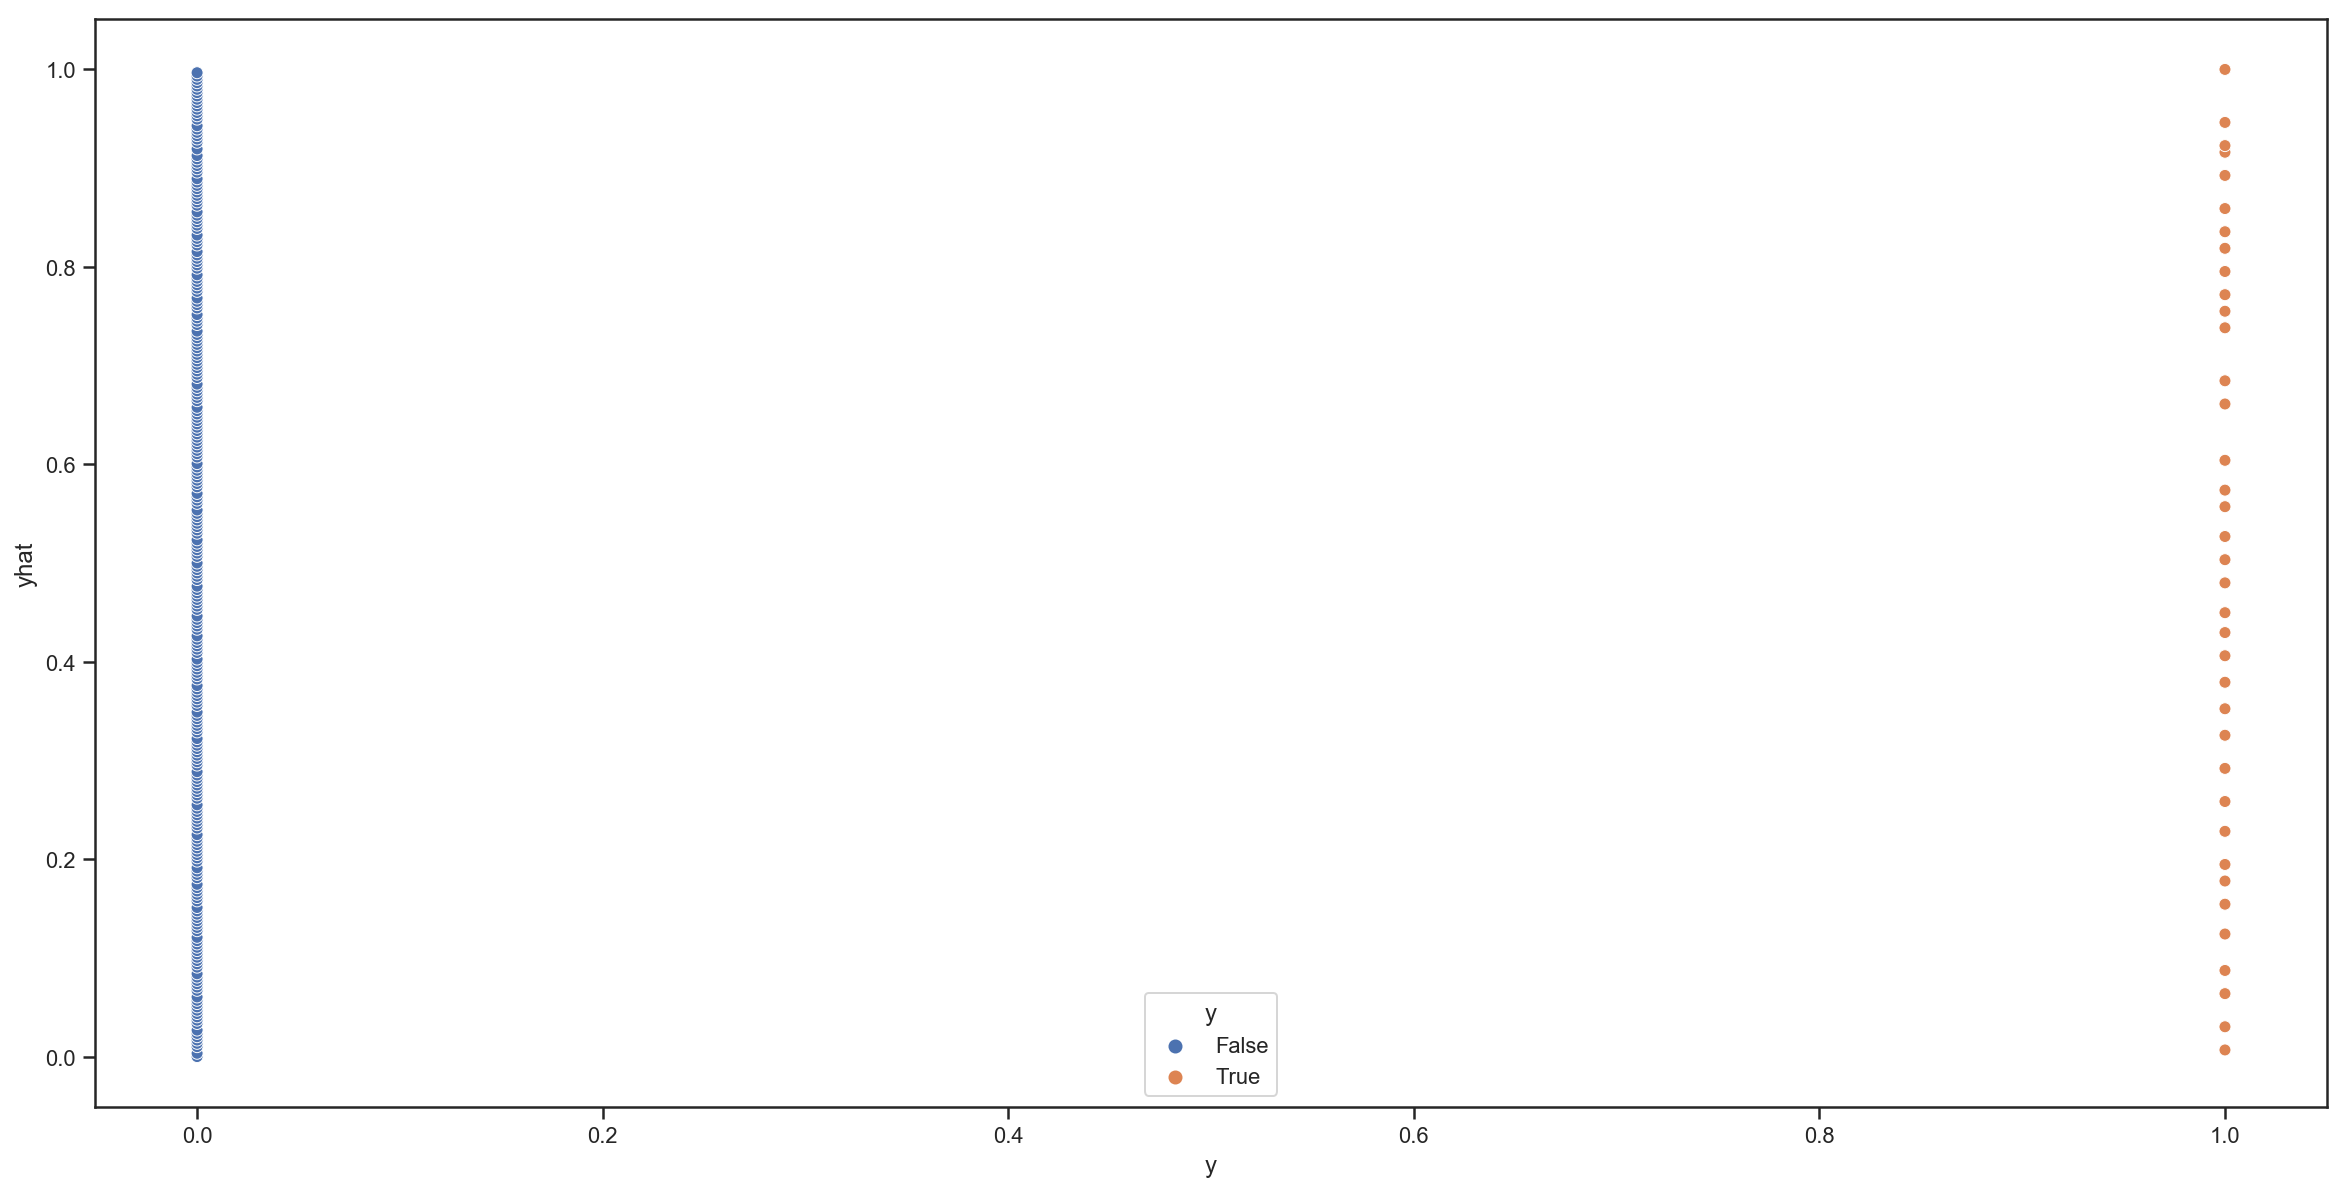

In [402]:
sns.scatterplot(data=predictions1, x="y", y="yhat", hue="y")

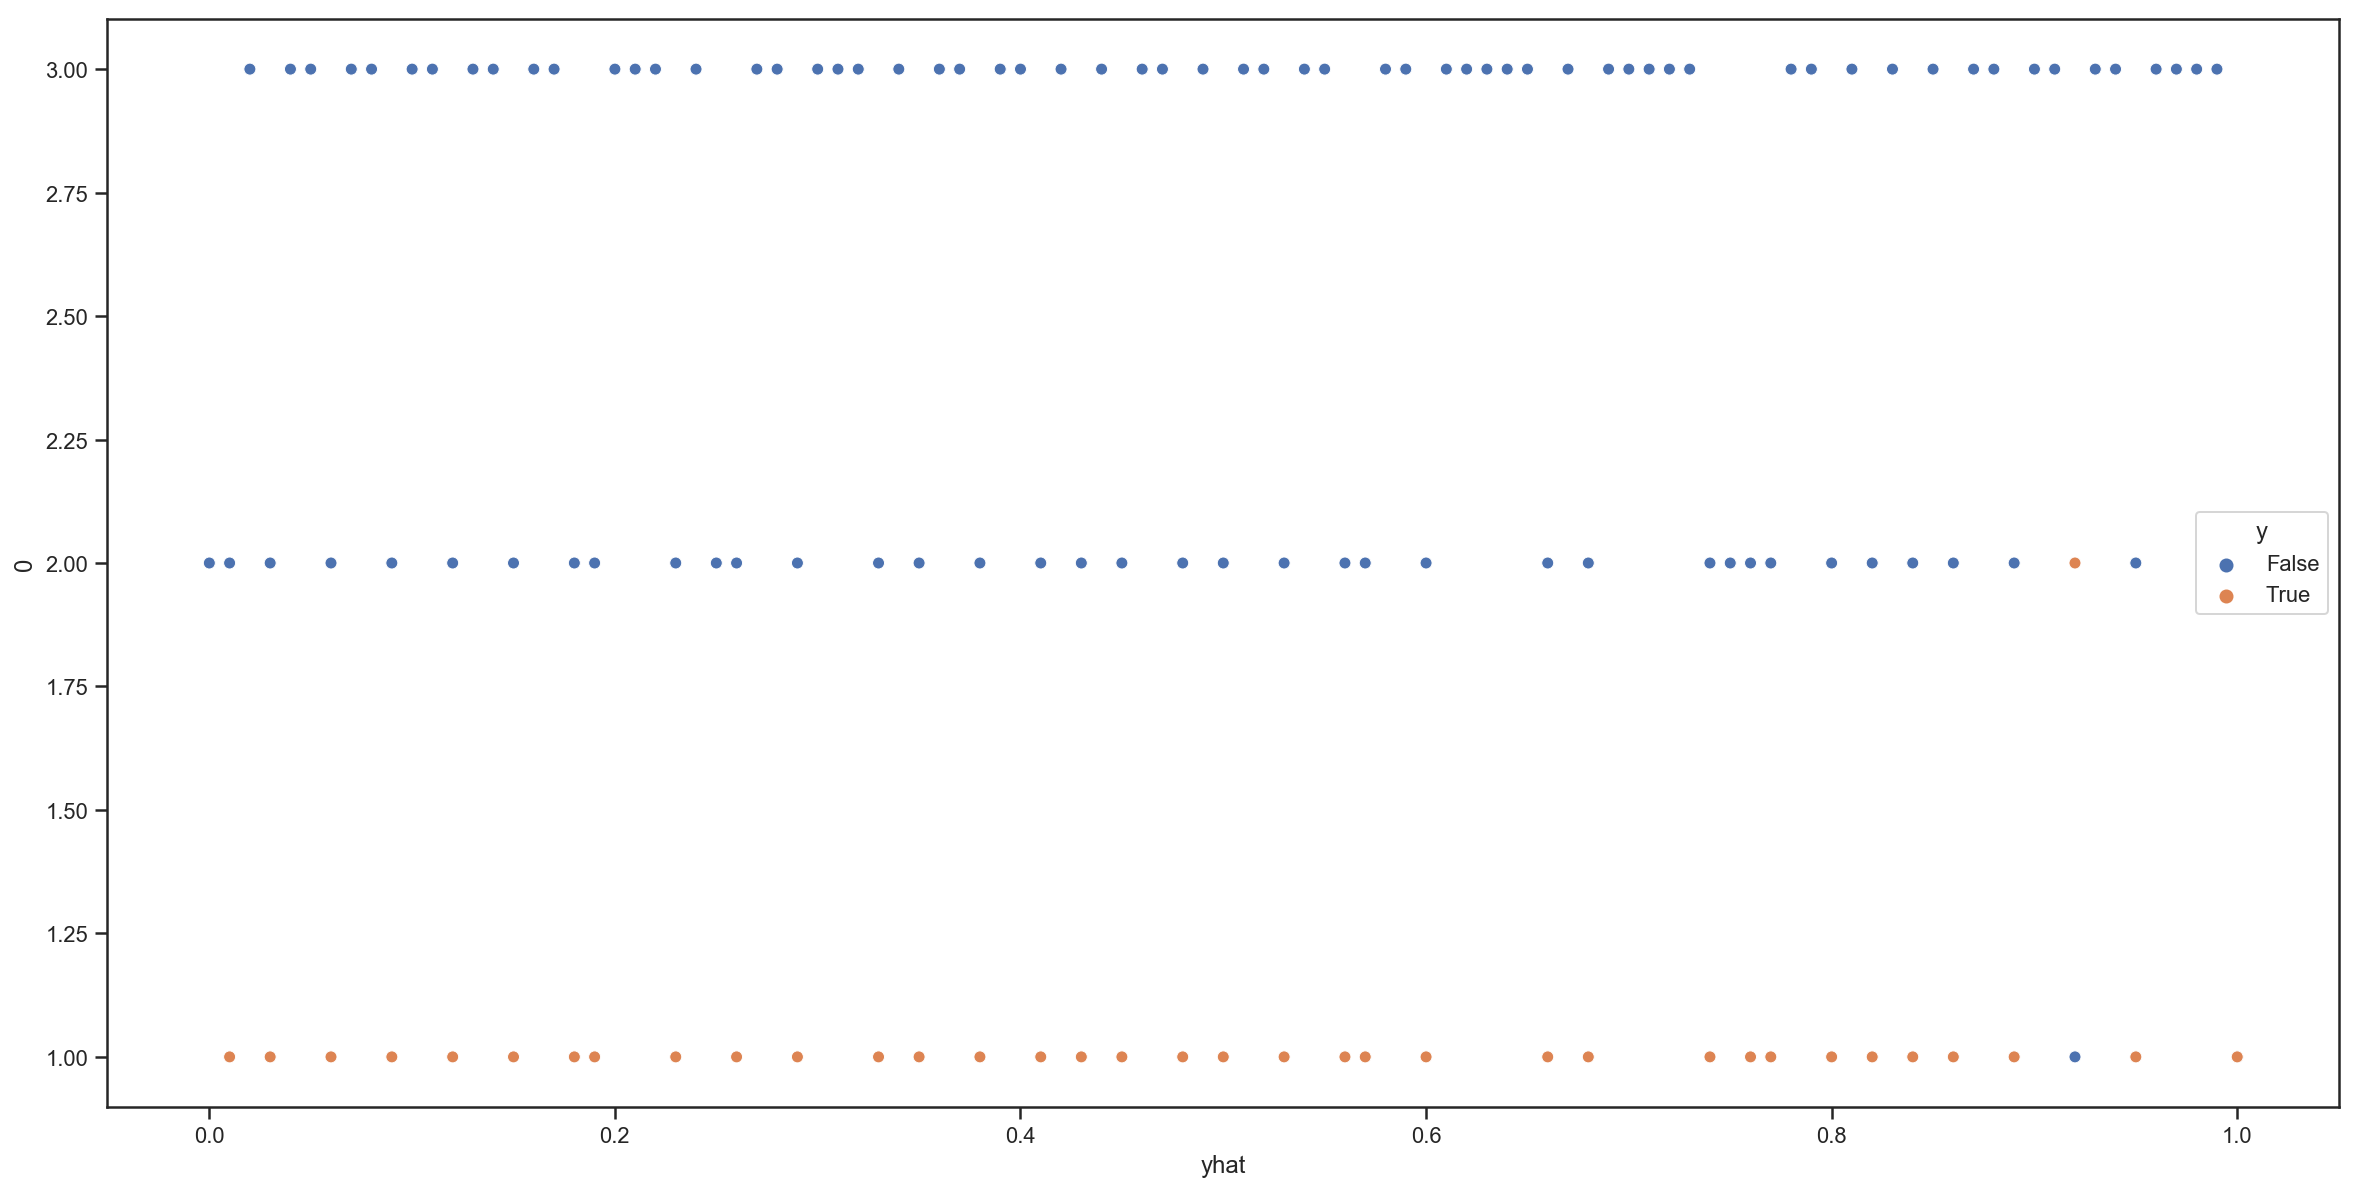

In [403]:
temp = predictions1.copy()
temp["yhat"] = temp["yhat"].round(2)
temp = temp.groupby(["y", "yhat"]).size().reset_index()
sns.scatterplot(data=temp, x="yhat", y=0, hue="y")

---

## Adding Weekly Seasonality

In [404]:
m2 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

In [405]:
m2.fit(train_df[["ds", "y"]])

In [406]:
predictions2 = m2.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions2["yhat"] = scaler.fit_transform(predictions2[["yhat"]])
predictions2["yhat"].describe()

count    299.000000
mean       0.576684
std        0.286771
min        0.000000
25%        0.434302
50%        0.661885
75%        0.787702
max        1.000000
Name: yhat, dtype: float64

In [407]:
predictions2 = predictions2.merge(test_df, on=["ds"])

In [408]:
predictions2[["y", "yhat"]].corr()

,y,yhat
y,1.00000,0.05936
yhat,0.05936,1.00000


---

## Weekly + Daily Seasonality

In [409]:
m3 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)

In [410]:
m3.fit(train_df[["ds", "y"]])

In [411]:
predictions3 = m3.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions3["yhat"] = scaler.fit_transform(predictions3[["yhat"]])
predictions3["yhat"].describe()

count    299.000000
mean       0.578571
std        0.292794
min        0.000000
25%        0.426871
50%        0.670634
75%        0.799849
max        1.000000
Name: yhat, dtype: float64

In [412]:
predictions3 = predictions3.merge(test_df, on=["ds"])

In [413]:
predictions3[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.059194
yhat,0.059194,1.000000


---

## Weekly + Yearly Seasonality

In [414]:
m4 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [415]:
m4.fit(train_df[["ds", "y"]])

In [416]:
predictions4 = m4.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions4["yhat"] = scaler.fit_transform(predictions4[["yhat"]])
predictions4["yhat"].describe()

count    299.000000
mean       0.587653
std        0.203227
min        0.000000
25%        0.480609
50%        0.617071
75%        0.725627
max        1.000000
Name: yhat, dtype: float64

In [417]:
predictions4 = predictions4.merge(test_df, on=["ds"])

In [418]:
predictions4[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.071071
yhat,0.071071,1.000000


---

## Weekly Seasonality + Yearly Seasonality + US Holidays

In [419]:
m5 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m5.add_country_holidays(country_name="US")

In [420]:
m5.fit(train_df[["ds", "y"]])

In [421]:
predictions5 = m5.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions5["yhat"] = scaler.fit_transform(predictions5[["yhat"]])
predictions5["yhat"].describe()

count    299.000000
mean       0.578482
std        0.211998
min        0.000000
25%        0.469983
50%        0.609518
75%        0.724811
max        1.000000
Name: yhat, dtype: float64

In [422]:
predictions5 = predictions5.merge(test_df, on=["ds"])

In [423]:
predictions5[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.064874
yhat,0.064874,1.000000


---

## Weekly Seasonality + US Holidays

In [424]:
m6 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m6.add_country_holidays(country_name="US")

In [425]:
m6.fit(train_df[["ds", "y"]])

In [426]:
predictions6 = m6.predict(test_df[["ds", "y"]])
scaler = MinMaxScaler()
predictions6["yhat"] = scaler.fit_transform(predictions6[["yhat"]])
predictions6["yhat"].describe()

count    299.000000
mean       0.643762
std        0.254173
min        0.000000
25%        0.517650
50%        0.730642
75%        0.854560
max        1.000000
Name: yhat, dtype: float64

In [427]:
predictions6 = predictions6.merge(test_df, on=["ds"])

In [428]:
predictions6[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.054044
yhat,0.054044,1.000000


---

## Weekly Seasonality + Days Since Previous Release

In [429]:
m7 = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
m7.add_regressor("days_since_previous_release")

In [430]:
m7.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [431]:
predictions7 = m7.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions7["yhat"] = scaler.fit_transform(predictions7[["yhat"]])
predictions7["yhat"].describe()

count    299.000000
mean       0.393584
std        0.180547
min        0.000000
25%        0.274080
50%        0.392411
75%        0.505670
max        1.000000
Name: yhat, dtype: float64

In [432]:
predictions7 = predictions7.merge(test_df, on=["ds"])

In [433]:
predictions7[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.287176
yhat,0.287176,1.000000


---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release

In [434]:
m8 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m8.add_regressor("days_since_previous_release")

In [435]:
m8.fit(train_df[["ds", "days_since_previous_release", "y"]])

In [436]:
predictions8 = m8.predict(test_df[["ds", "days_since_previous_release", "y"]])
scaler = MinMaxScaler()
predictions8["yhat"] = scaler.fit_transform(predictions8[["yhat"]])
predictions8["yhat"].describe()

count    299.000000
mean       0.438492
std        0.165846
min        0.000000
25%        0.326382
50%        0.436361
75%        0.541110
max        1.000000
Name: yhat, dtype: float64

In [437]:
predictions8 = predictions8.merge(test_df, on=["ds"])

In [438]:
predictions8[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.296612
yhat,0.296612,1.000000


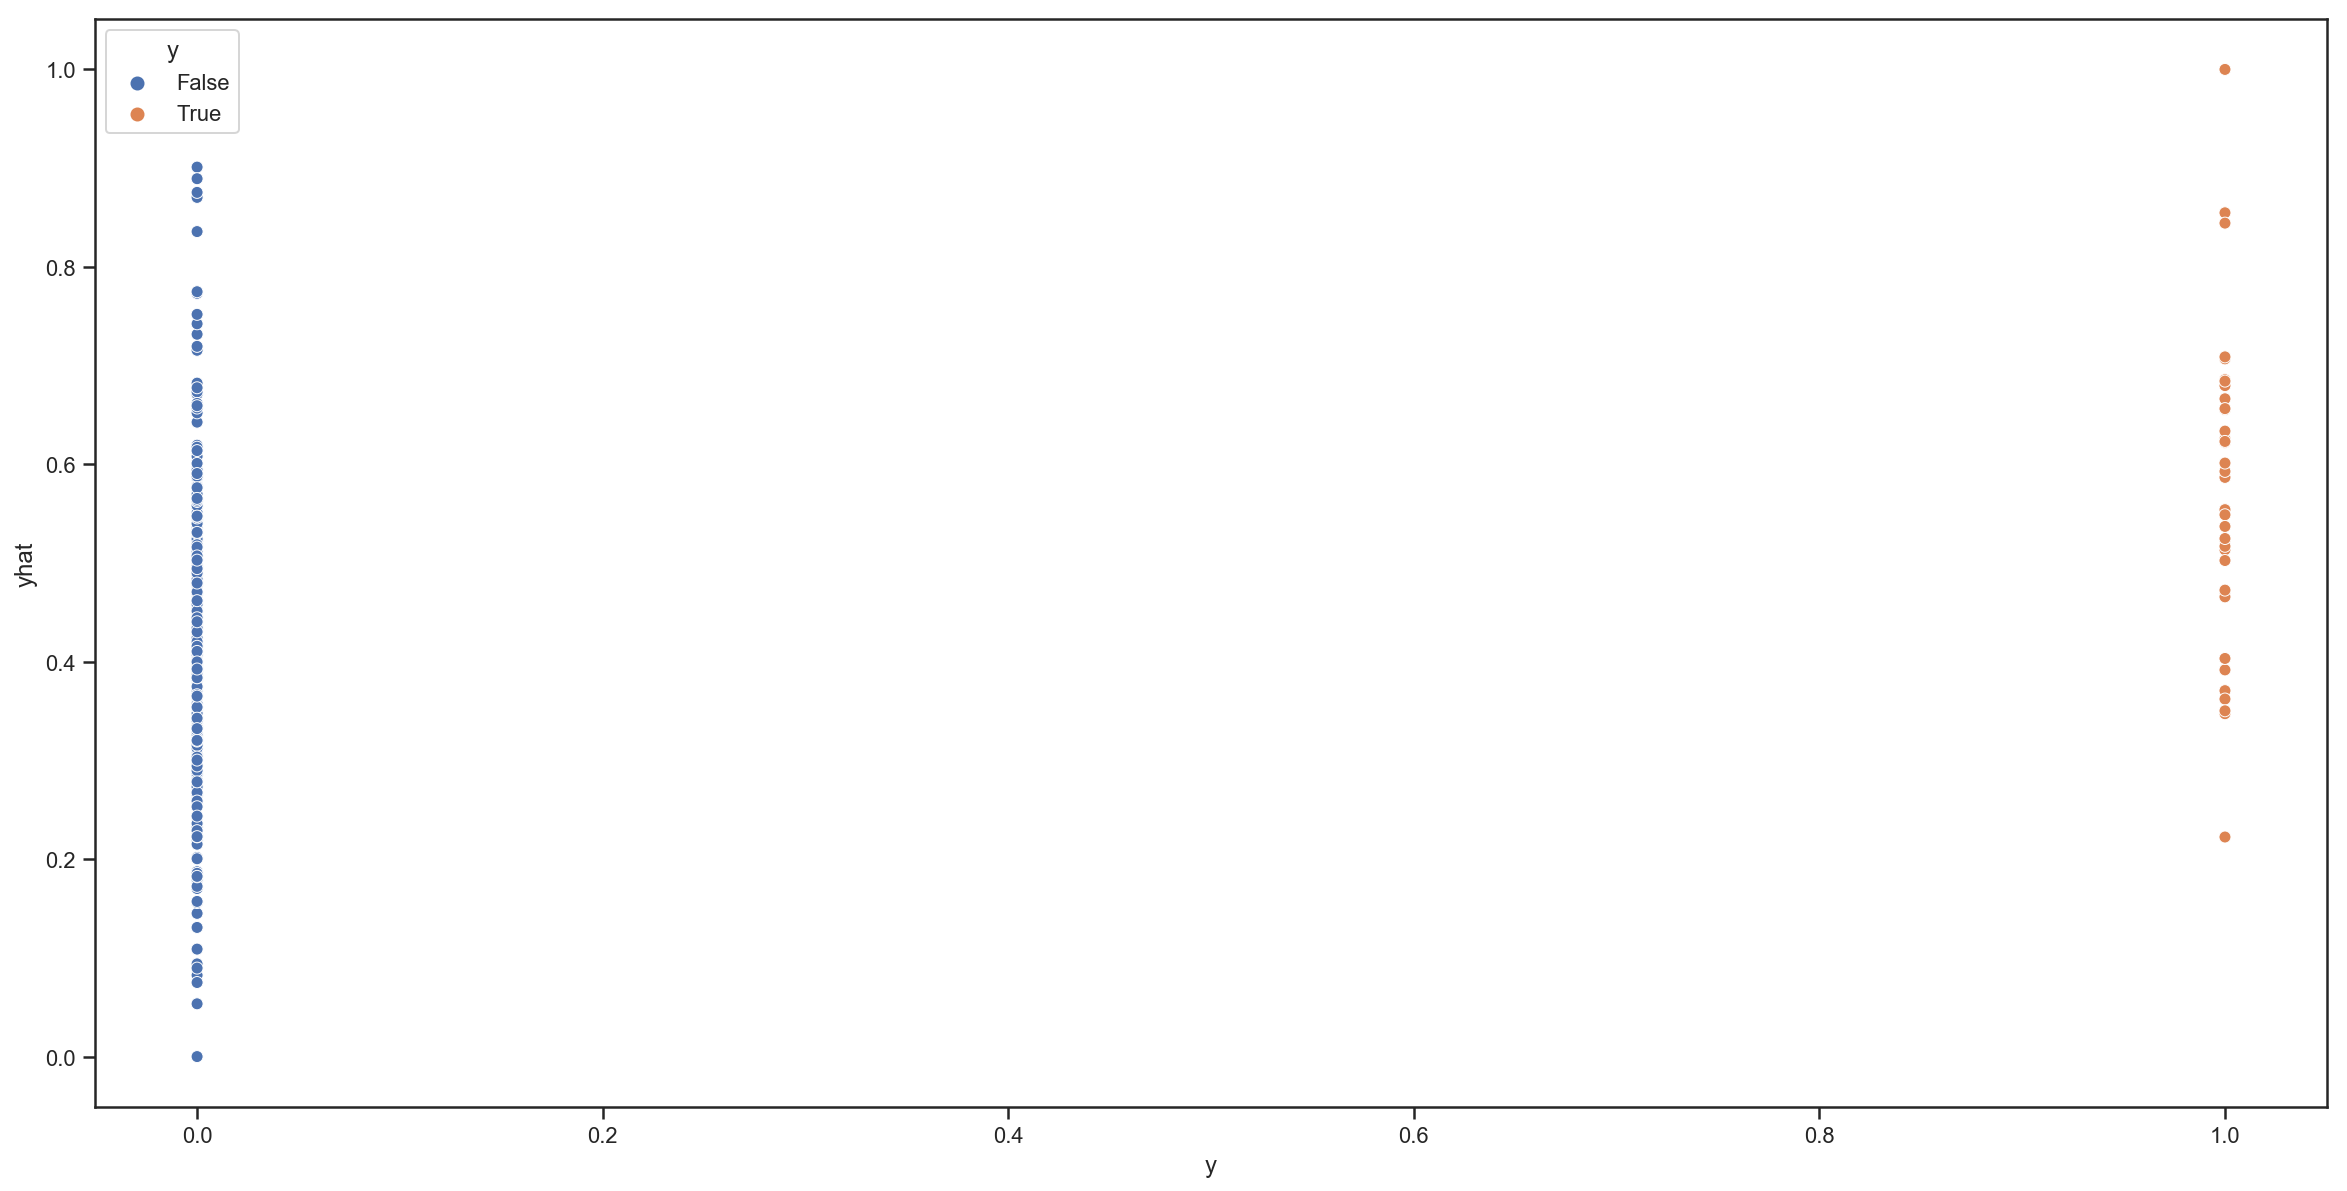

In [439]:
sns.scatterplot(data=predictions8, x="y", y="yhat", hue="y")

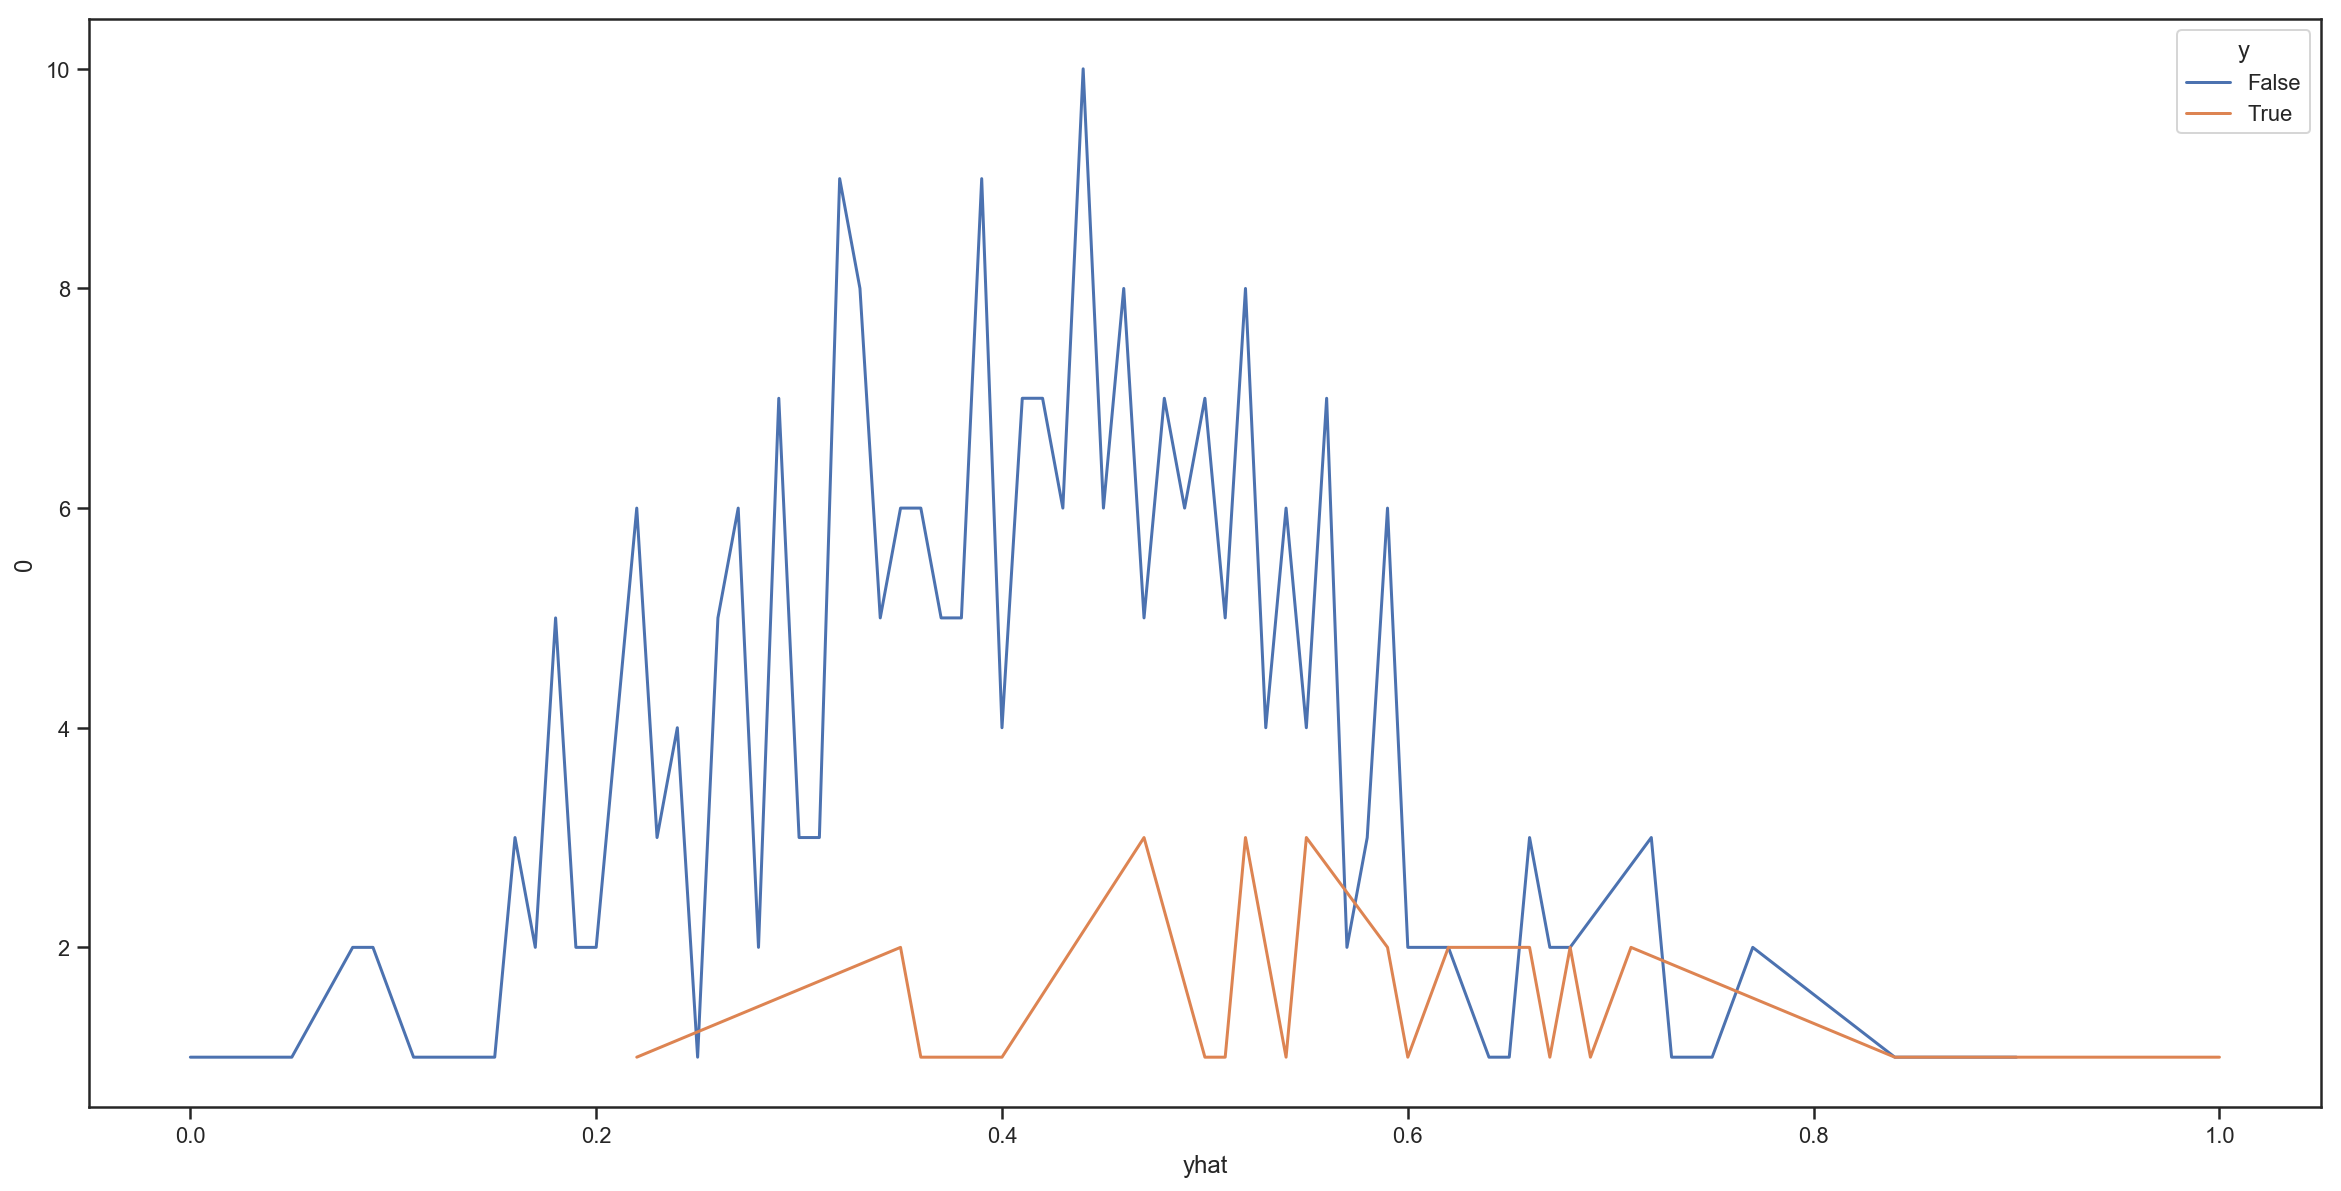

In [440]:
temp = predictions8.copy()
temp["yhat"] = temp["yhat"].round(2)
temp = temp.groupby(["y", "yhat"]).size().reset_index()
sns.lineplot(data=temp, x="yhat", y=0, hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday

In [441]:
m9 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m9.add_regressor("days_since_previous_release")
m9.add_regressor("weekday")

In [442]:
m9.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [443]:
predictions9 = m9.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions9["yhat"] = scaler.fit_transform(predictions9[["yhat"]])
predictions9["yhat"].describe()

count    299.000000
mean       0.438122
std        0.166118
min        0.000000
25%        0.325919
50%        0.436589
75%        0.540475
max        1.000000
Name: yhat, dtype: float64

In [444]:
predictions9 = predictions9.merge(test_df, on=["ds"])

In [445]:
predictions9[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.296624
yhat,0.296624,1.000000


---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays

In [446]:
m10 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m10.add_regressor("days_since_previous_release")
m10.add_regressor("weekday")
m10.add_country_holidays(country_name="US")

In [447]:
m10.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [448]:
predictions10 = m10.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions10["yhat"] = scaler.fit_transform(predictions10[["yhat"]])
predictions10["yhat"].describe()

count    299.000000
mean       0.435317
std        0.166174
min        0.000000
25%        0.322860
50%        0.435198
75%        0.538544
max        1.000000
Name: yhat, dtype: float64

In [449]:
predictions10 = predictions10.merge(test_df, on=["ds"])

In [450]:
predictions10[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.297813
yhat,0.297813,1.000000


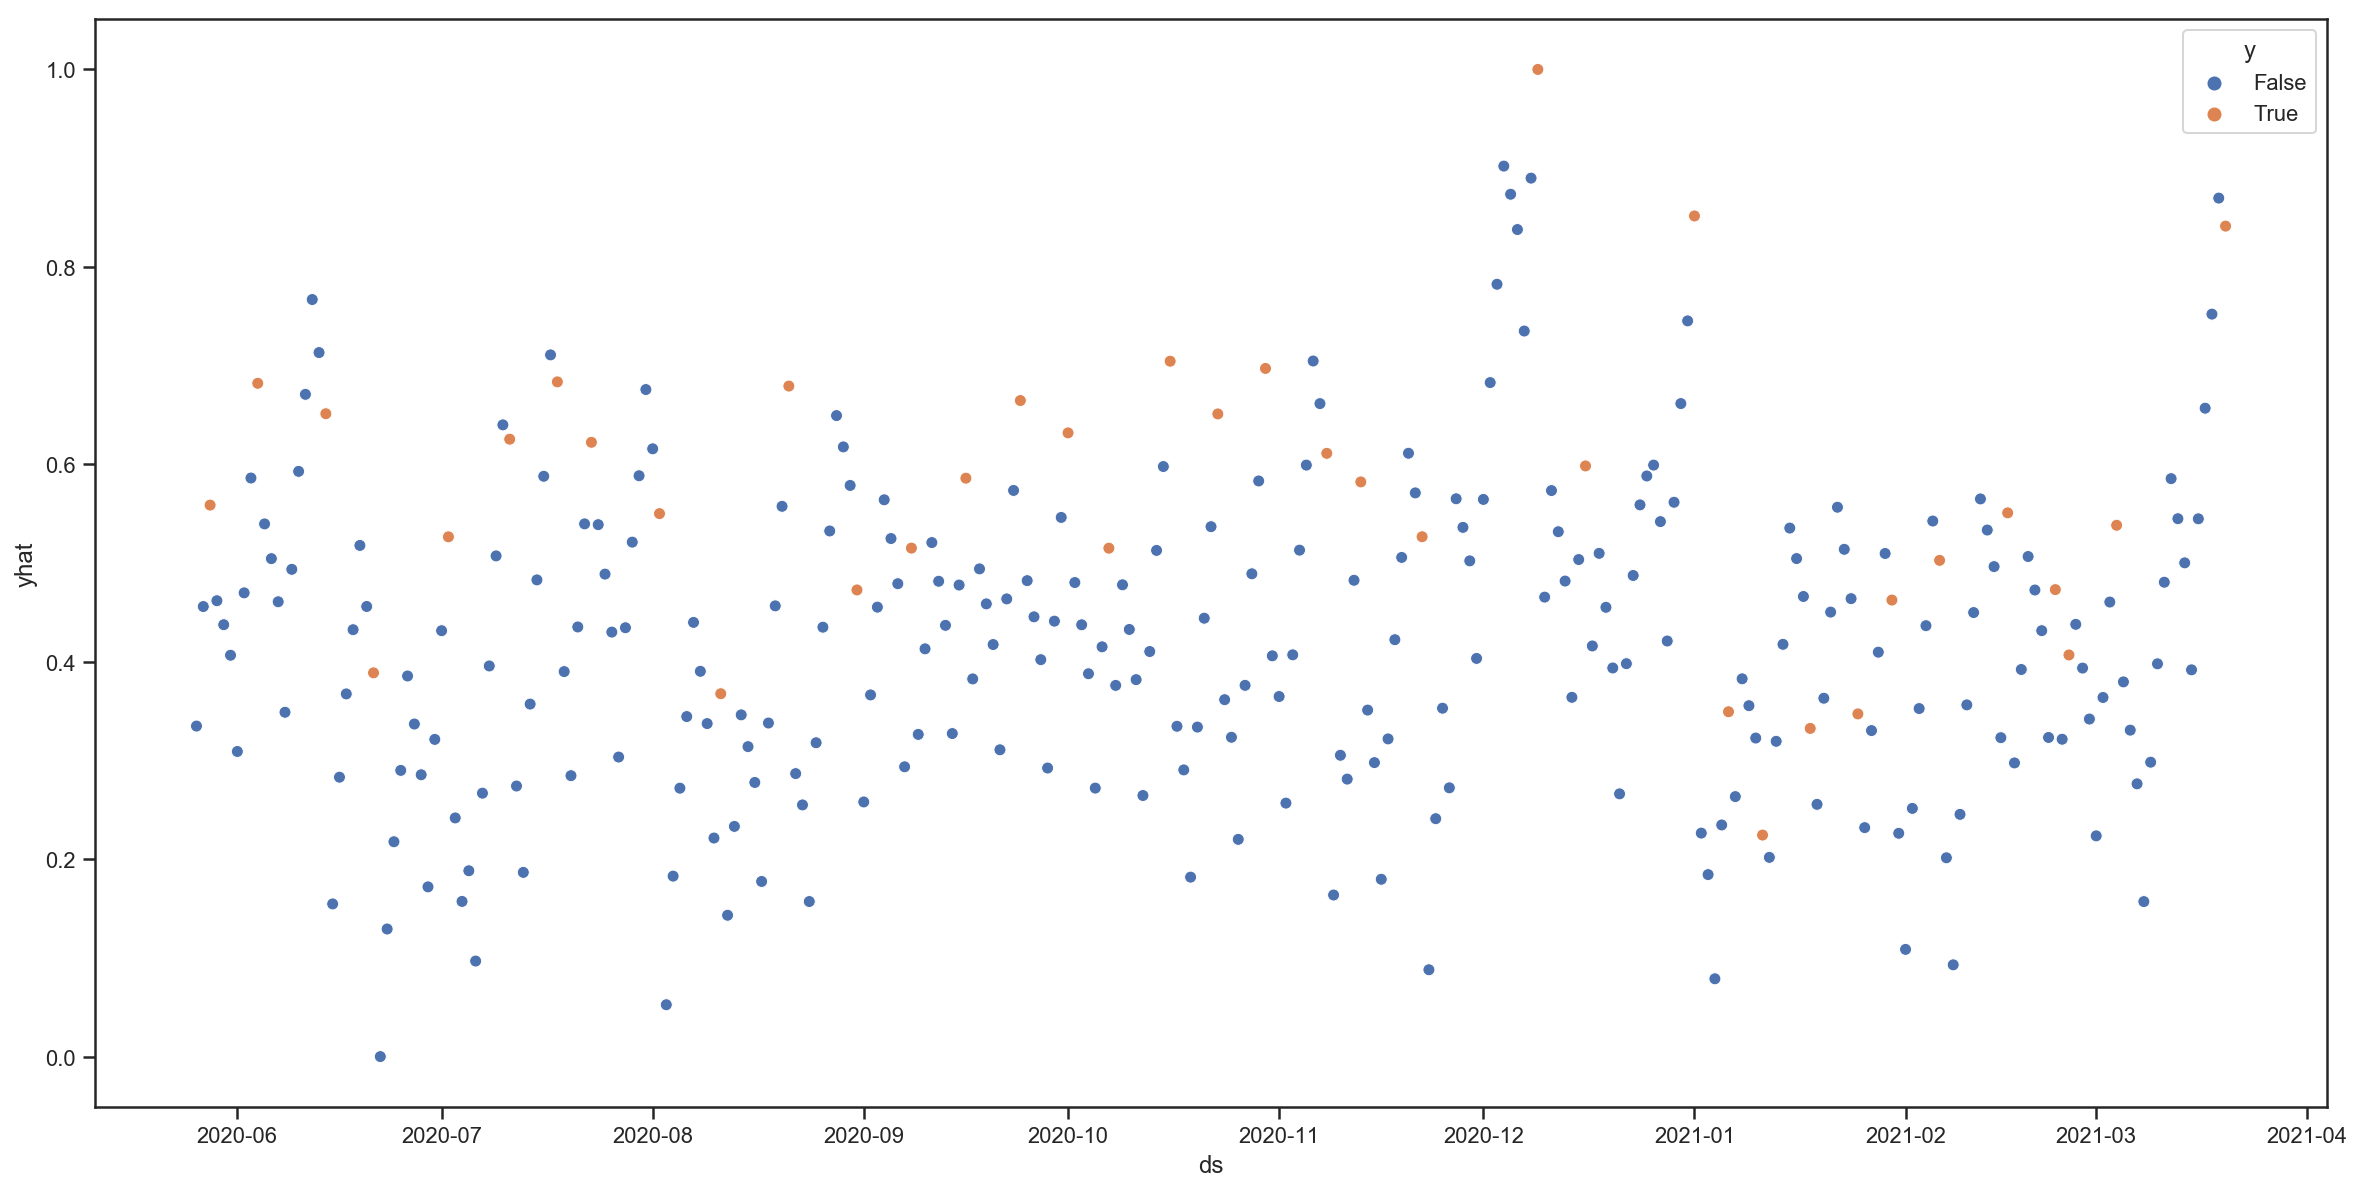

In [451]:
sns.scatterplot(data=predictions10, x="ds", y="yhat", hue="y")

---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Multiplicative Seasonality

In [454]:
m11 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_mode="multiplicative")
m11.add_regressor("days_since_previous_release")
m11.add_regressor("weekday")
m11.add_country_holidays(country_name="US")

In [455]:
m11.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [456]:
predictions11 = m11.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions11["yhat"] = scaler.fit_transform(predictions11[["yhat"]])
predictions11["yhat"].describe()

count    299.000000
mean       0.438989
std        0.168010
min        0.000000
25%        0.327859
50%        0.434483
75%        0.537167
max        1.000000
Name: yhat, dtype: float64

In [457]:
predictions11 = predictions11.merge(test_df, on=["ds"])

In [458]:
predictions11[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.293501
yhat,0.293501,1.000000


---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase

In [481]:
m12 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m12.add_regressor("days_since_previous_release")
m12.add_regressor("weekday")
m12.add_country_holidays(country_name="US")

In [482]:
m12.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [483]:
predictions12 = m12.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions12["yhat"] = scaler.fit_transform(predictions12[["yhat"]])
predictions12["yhat"].describe()

count    299.000000
mean       0.435019
std        0.166274
min        0.000000
25%        0.321986
50%        0.435148
75%        0.538037
max        1.000000
Name: yhat, dtype: float64

In [484]:
predictions12 = predictions12.merge(test_df, on=["ds"])

In [485]:
predictions12[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.297888
yhat,0.297888,1.000000


---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release

In [590]:
m13 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
              seasonality_prior_scale=100)
m13.add_regressor("days_since_previous_release", mode="multiplicative")
m13.add_regressor("weekday")
m13.add_country_holidays(country_name="US")

In [591]:
m13.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [600]:
predictions13 = m13.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions13["yhat"] = scaler.fit_transform(predictions13[["yhat"]])
predictions13["yhat"].describe()

count    299.000000
mean       0.433403
std        0.166022
min        0.000000
25%        0.320631
50%        0.432748
75%        0.534982
max        1.000000
Name: yhat, dtype: float64

In [601]:
predictions13 = predictions13.merge(test_df, on=["ds"])

In [602]:
predictions13[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.298406
yhat,0.298406,1.000000


---

## Weekly Seasonality + Yearly Seasonality + Days Since Previous Release + Weekday + US Holidays + Seasonality Prior Scale Increase + Multiplicative Days Since Previous Release + Fourier Terms on Yearly and Weekly Seasonality

In [644]:
m14 = Prophet(yearly_seasonality=10, weekly_seasonality=10, daily_seasonality=False, 
              seasonality_prior_scale=100)
m14.add_regressor("days_since_previous_release", mode="multiplicative")
m14.add_regressor("weekday")
m14.add_country_holidays(country_name="US")

In [645]:
m14.fit(train_df[["ds", "days_since_previous_release", "weekday", "y"]])

In [646]:
predictions14 = m14.predict(test_df[["ds", "days_since_previous_release", "weekday", "y"]])
scaler = MinMaxScaler()
predictions14["yhat"] = scaler.fit_transform(predictions14[["yhat"]])
predictions14["yhat"].describe()

count    299.000000
mean       0.433570
std        0.166161
min        0.000000
25%        0.321500
50%        0.433186
75%        0.535388
max        1.000000
Name: yhat, dtype: float64

In [647]:
predictions14 = predictions14.merge(test_df, on=["ds"])

In [648]:
predictions14[["y", "yhat"]].corr()

,y,yhat
y,1.000000,0.298757
yhat,0.298757,1.000000


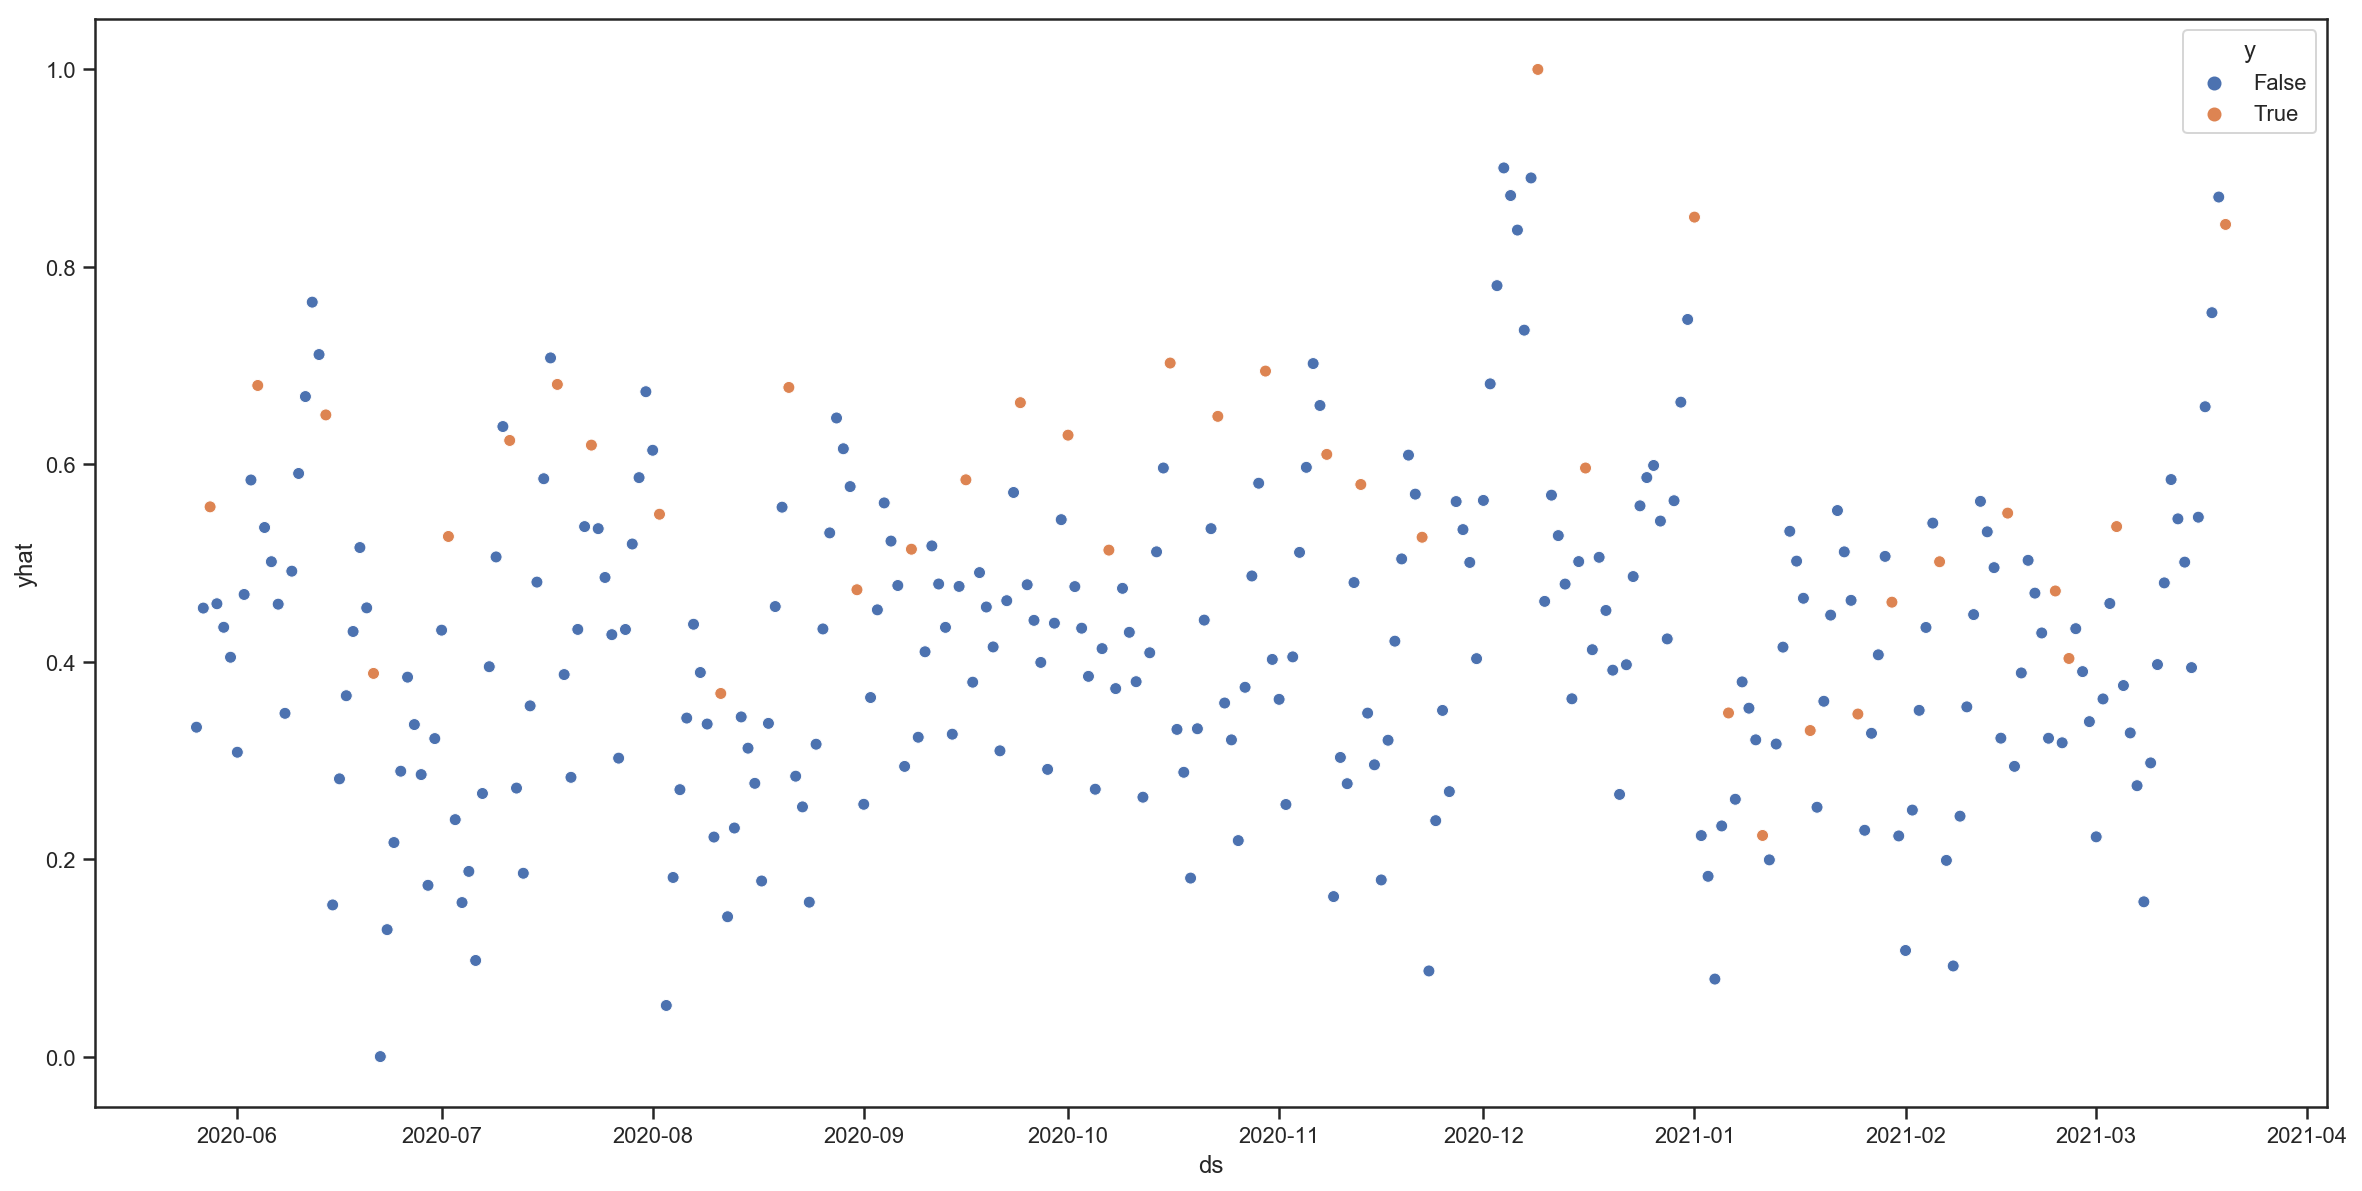

In [649]:
sns.scatterplot(data=predictions14, x="ds", y="yhat", hue="y")